1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [44]:
from scipy import optimize
import numpy as np

f =  lambda x: (4 - 2.1 * x[0] ** 2 + x[0] ** 4 / 3) * x[0] ** 2 + x[0] * x[1] + (4 * x[1] ** 2 - 4) * x[1] ** 2
starting_points_x = np.linspace(-2, 2, 20)
starting_points_y = np.linspace(-1, 1, 20)

res = [optimize.minimize(f, (x, y)).x for x in starting_points_x for y in starting_points_y]
min_x = np.array([f(x) for x in res]).argmin()
print(res[min_x], f(res[min_x]))
# for x,y = 0,0 the minimization converge almost immediately at the local minimum (0,0)

[-0.08984202  0.7126564 ] -1.0316284534898772


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?

* Is the time offset for min and max temperatures the same within the fit accuracy?

<IPython.core.display.Javascript object>


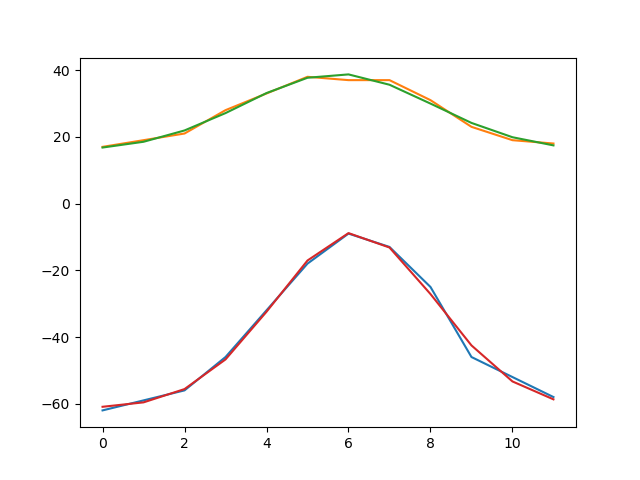

[ 5.7358151  10.52880906 23.09206185 15.7793612 ]
[  6.16452601   7.80836196  52.64929169 -61.32093521]


In [19]:
%matplotlib notebook 
import matplotlib.pyplot as plt
import numpy as np

max_temp = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
min_temp = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

x = np.array(list(range(len(min_temp))))
plt.plot(x, min_temp)
plt.plot(x, max_temp)

f = lambda x, x0, s, a, b: a * np.exp(-(x-x0)**2 / s) + b
popt, pcov = optimize.curve_fit(f, x, max_temp, p0=[6, 2, 10, 20])
print(popt)
plt.plot(x, [f(i, *popt) for i in x])
popt, pcov = optimize.curve_fit(f, x, min_temp, p0=[6, 2, 10, -60])
plt.plot(x, [f(i, *popt) for i in x])
print(popt)
# The results are reasonable, 

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

{'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
        0.16666667,  0.08333333]), 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])}


<IPython.core.display.Javascript object>


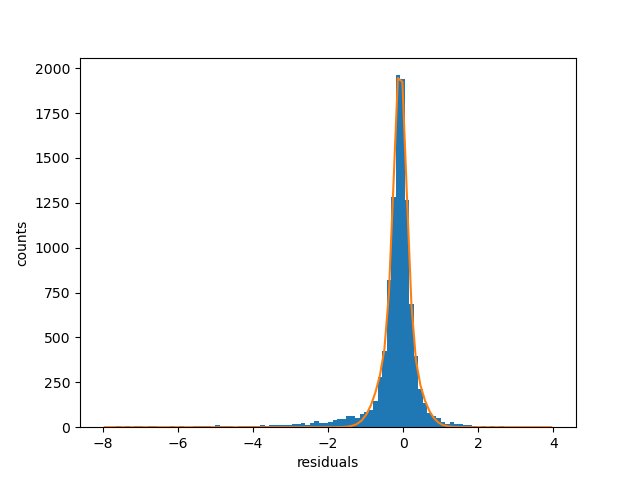

[-8.13196868e-02  5.29621408e-02  1.46567742e+03  5.72784185e+02
 -1.14787314e-01  3.58389547e-01]
chi2 = 5046.56
p-value = 0.0


In [57]:
from os.path import exists
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats
import numpy as np
%matplotlib notebook 

if not exists('data/residuals_261.pkl'):
    !wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
data = pd.read_pickle('data/residuals_261.pkl').item()
print(data)
n_bins=100
plt.hist(data['residuals'], bins = n_bins, range=[-8, 4])
plt.ylabel('counts')
plt.xlabel('residuals')
hist, bin_edges = np.histogram(data['residuals'], bins=n_bins, range=[-8, 4])
poisson_sigma = np.sqrt(hist)
f = lambda x, x0, s, a, b, x1, s1: a * np.exp(-(x-x0)**2 / s) + b * np.exp(-(x-x1)**2 / s1)
x = (bin_edges[0:-1] + bin_edges[1:]) / 2
popt, pcov = optimize.curve_fit(f, x, hist, p0=[0., 1., 2000, 1000, 0, 10.])
print(popt)
y_hat = np.array([f(i, *popt) for i in x])
plt.plot(x, y_hat)
plt.show()
poisson_sigma[hist == 0] = 0.001
chi2 = np.sum(((hist - y_hat)**2) / poisson_sigma)
ndof = len(x) - 5
print("chi2 = %.2f" % chi2)
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

[-9.67127679 12.34271735  9.0525621 ]


<IPython.core.display.Javascript object>


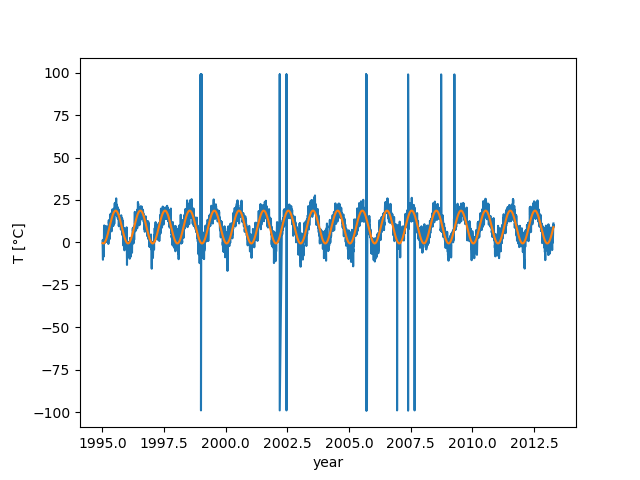

mean temperature: 8.941907 °C
daily average values  hottest temperature: 18.723639 °C
daily average values  coldest temperature: -0.618715 °C
SSR: 694209.8326248894 694186.2523477275
CL: 0.634 , additional parameter necessary: NO


In [58]:
from os.path import exists
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats
import numpy as np
%matplotlib notebook 

if not exists('data/munich_temperatures_average_with_bad_data.txt'):
    !wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt -P data/

f = lambda t, a, b, c: a * np.cos(2 * np. pi * t + b) + c
data = np.loadtxt('data/munich_temperatures_average_with_bad_data.txt')
popt, pcov = optimize.curve_fit(f, data[:, 0], data[:, 1])
print(popt)
y_hat = f(data[:, 0], *popt)
plt.plot(data[:, 0], data[:, 1])
plt.plot(data[:, 0], y_hat)
plt.xlabel('year')
plt.ylabel('T [°C]')
plt.show()
print('mean temperature: %f °C' % y_hat.mean())
print('daily average values  hottest temperature: %f °C' % y_hat.max())
print('daily average values  coldest temperature: %f °C' % y_hat.min())

# The b parameter is the phase of the temperature oscillations

g = lambda t, a, b, c, d: a * np.cos(2 * b * np. pi * t + c) + d
popt_g, pcov = optimize.curve_fit(g, data[:, 0], data[:, 1])
y_hat_g = g(data[:, 0], *popt_g)

ssr_f = np.sum((y_hat - data[:, 1])**2)
ssr_g = np.sum((y_hat_g - data[:, 1])**2)
ndof_f = len(popt) - 1
ndof_g = len(popt_g) - 1
print("SSR:", ssr_f, ssr_g)


# define function for F-test
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

cl_1_vs_2 = Ftest(ssr_f, ssr_g, ndof_f, ndof_g, len(data[:,0]), verbose=True)